### Import required libaries

In [1]:
import os
from dotenv import load_dotenv
from dataclasses import dataclass

In [2]:
from langchain.agents import create_agent
from langchain_openai import AzureChatOpenAI
from langchain_community.utilities import SQLDatabase
from langchain.tools import tool, ToolRuntime

In [3]:
load_dotenv()

True

In [4]:
llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_ENDPOINT"],
    azure_deployment=os.environ["OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["OPENAI_API_VERSION"],
)

In [5]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

### Define Runtime context

In [6]:
# define context structure to support dependency injection
@dataclass
class RunTimeContext:
    db: SQLDatabase

### Define tools

In [7]:
# define tool
@tool
def execute_sql(query: str, 
                runtime: ToolRuntime[RunTimeContext]) -> str:
    """Execute SQLite command and return results"""
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [8]:
# define system prompt

SYSTEM_PROMPT = """You are an expert SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- perform ONLY Read-only operations; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

### Define agent

In [9]:
# define agent
agent = create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RunTimeContext,
)

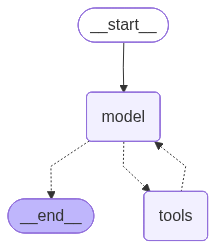

In [10]:
agent

### Invoke agent in streaming mode

In [11]:
## Example 1

my_query = "Which table has got the largest number of rows?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": my_query}]},
    context=RunTimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has got the largest number of rows?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_uadHr90QRybtk6ZiuFZEHVQ8)
 Call ID: call_uadHr90QRybtk6ZiuFZEHVQ8
  Args:
    query: SELECT name FROM sqlite_schema WHERE type = 'table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_4ywemH0v0wPeATLEybE3YoUR)
 Call ID: call_4ywemH0v0wPeATLEybE3YoUR
  Args:
    query: SELECT table_name, row_count FROM (
  SELECT 'Album' AS table_name, (SELECT COUNT(*) FROM Album) AS row_count
  UNI

In [12]:
## Example 2

my_query = "Create a JSON report showing table and number of rows in the table. The report should show all tables in the database"

for step in agent.stream(
    {"messages": [{"role": "user", "content": my_query}]},
    context=RunTimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Create a JSON report showing table and number of rows in the table. The report should show all tables in the database
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_fwffmZPWVnoNzHCg3ELzN4Xg)
 Call ID: call_fwffmZPWVnoNzHCg3ELzN4Xg
  Args:
    query: SELECT name FROM sqlite_master WHERE type = 'table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_0bJSZ0ac0lAKzuq0zZsVteWK)
 Call ID: call_0bJSZ0ac0lAKzuq0zZsVteWK
  Args:
    query: SELECT 'Album' AS table_name, COUNT(*) AS row